In [1]:
import torch
import numpy as np
import torchvision
import tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import shutil
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torchvision.models import resnet18, resnet152

In [ ]:
!unzip bhw1.zip -d bhw1

Привет! В этом блокноте я буду делать бдз1 по дл (делать буду в кагле, надеюсь, что ничего не напутал с версиями и тд). Очень много кода я взял из сема https://github.com/isadrtdinov/intro-to-dl-hse/blob/2023-2024/seminars/211/Seminar_4_DL_1.ipynb по дл. В качестве 10% асс я возьму свой бэйзлайн для себя. Тип зачем мне изобретать велосипед, возьму популярную cnn resnet из библиотеки pytorch (ну по сути можно), предобучать ее не буду, так как это бан

In [ ]:
# torch.save(net.state_dict(), "weights.pt")
# net.load_state_dict(torch.load("weights.pt"))

In [2]:
PATH = '/home/jupyter/datasphere/project/bhw1/bhw1/bhw1/'
TEST_SIZE = 0.5
SPLIT_RANDOM_SEED = 42

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
data = pd.read_csv(PATH + 'labels.csv')
data.head()

,Id,Category
0,trainval_00000.jpg,7
1,trainval_00001.jpg,198
2,trainval_00002.jpg,161
3,trainval_00003.jpg,131
4,trainval_00004.jpg,107


In [ ]:
data['Category'].unique()

array([  7, 198, 161, 131, 107, 194,  77,  73, 150,   2,  59,  83, 158,
        14,  35, 135, 130,  40, 189, 172, 190,  17, 186, 182,  56, 196,
        69, 122,   0,  50, 178, 185,  15, 100, 123,  55, 162, 134,  19,
        26,  82, 197, 112, 193,  46, 128, 136,  31,  43,  53, 137,  91,
        39,  33,  37, 165, 124, 113,  27,  34,  49,  23, 125, 119,  97,
       180,  64, 104,  10, 168, 105,  71,  94,  54,  47,  13, 164, 167,
       159, 152, 109,  88,  24,  99, 144, 173,  48,  52,  62,  21, 199,
        79,  81,  78, 118,  87,  28,   8,  75, 157,  42,  44,  66,  92,
       151,  72,  30, 142, 171,  67, 179, 188, 155, 101, 146, 143, 139,
       140,  96,  60,  45, 129,  61,   9,  20,  68,  74, 177, 153, 195,
        86,  11, 132, 121,  58,  41,  95, 149, 191, 120,  22,  57,  76,
        85,   1, 174, 181, 116, 138, 111,   6, 163, 103, 175, 156, 110,
        63,  98, 114, 160, 141, 192, 184, 145,  51,  80,  32,  12, 169,
        25, 127, 102, 147, 148, 108,  89,   3,  90, 106, 133,  2

In [5]:
class ImageDataset(Dataset):
    TEST_SIZE = 0.5
    SPLIT_RANDOM_SEED = 42

    def __init__(self, root, data, test_size = 0.5, train=True, load_to_ram=True, transform=None, trainval=True):
        super().__init__()
        self.TEST_SIZE = test_size
        self.root = root
        self.train = train
        self.trainval = trainval
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        if trainval:
            self.classes = sorted(data['Category'].unique())
            for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
                files = data[data['Category'] == class_name]['Id']
                train_files, test_files = train_test_split(files.to_list(), random_state=self.SPLIT_RANDOM_SEED + i, test_size=self.TEST_SIZE)
                if self.train:
                    self.all_files += train_files
                    self.all_labels += [class_name] * len(train_files)
                    if self.load_to_ram:
                        self.images += self._load_images(train_files)

                else:
                    self.all_files += test_files
                    self.all_labels += [class_name] * len(test_files)
                    if self.load_to_ram:
                        self.images += self._load_images(test_files)
        else:
            for file_name in tqdm(data['Id'].to_list(), total=data.shape[0]):
                self.all_labels += [file_name]
                self.all_files += [file_name]
                image = Image.open(os.path.join(self.root, 'test/', file_name)).convert('RGB')
                self.images += [image]

    def _load_images(self, image_files):
        images = []
        for filename in image_files:
            add = 'trainval/' if self.trainval else 'test/'
            image = Image.open(os.path.join(self.root, add, filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            add = 'trainval/' if self.trainval else 'test/'
            image = Image.open(os.path.join(self.root, add, filename)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [6]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        if test_loader is not None:
            test_loss, test_accuracy = validation_epoch(
                model, criterion, test_loader,
                tqdm_desc=f'Validating {epoch}/{num_epochs}'
            )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)
        print(test_accuracies[-1])
#         torch.save(model.state_dict(), "weights.pt")

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

num_epochs = 30
model = resnet18(num_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
answer = pd.read_csv(PATH + 'sample_submission.csv')
answer.head()

In [ ]:
answer.shape

In [ ]:
test_dataset = ImageDataset(root=PATH, data=answer, train=False, load_to_ram=True, transform=test_transform, trainval=False)
test_loader = DataLoader(test_dataset, batch_size=answer.shape[0], shuffle=False, pin_memory=True, num_workers=4)

In [ ]:
for images, labels in test_loader:
    images = images.to(device)
    y_pred = model(images)
    print(len(y_pred))

In [ ]:
y_pred = y_pred.argmax(dim=1).cpu()
y_pred

In [ ]:
answer['Category'] = y_pred
answer.head()

In [ ]:
answer.set_index('Id', inplace=True)
answer.head()

In [ ]:
answer.to_csv('solution.csv')

In [ ]:
from torchvision.models import resnet18

num_epochs = 30
model = resnet18(num_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

#lambda1 = lambda epoch: 1 / (epoch + 1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

#scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=15, power=1.0)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

немного решил поперебирать шедулеры и аугментацию из:
T.RandomHorizontalFlip(),
T.RandomGrayscale(),
T.RandomPerspective(),
T.RandomRotation(degrees=45) - чисто ради эксперимента и интереса (ну нам это очевидно нужно, смотрим на график), проводил я все тесты на test_split = 0.5 (делил данные пополам)

* SGD lr=0.1 m=0.9 ----> 0.19802
* SGD(lr=0.1 m=0.9) + CyclicLR(0.01, 0.1) ----> 0.20004
* SGD(lr=0.1 m=0.9) + LambdaLR ----> 0.1452
* SGD(lr=0.1 m=0.9) + CosineAnnealingLR ----> 0.1994

* SGD(lr=0.1 m=0.9) + CyclicLR(0.01, 0.1) + RandomHorizFlip ----> 0.23708
* SGD(lr=0.1 m=0.9) + CyclicLR(0.01, 0.1) + RandomHorizFlip + RandomGray ----> 0.21022
* SGD(lr=0.1 m=0.9) + CyclicLR(0.01, 0.1) + C(RandomHorizFlip, RandomGray) ----> 0.2136
* SGD(lr=0.1 m=0.9) + CyclicLR(0.01, 0.1) + RandomHorizFlip + RandomPerspect ----> 0.22146

In [ ]:
# начало главы "Первый вариант"

In [ ]:
class BasicBlockNet(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)
        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(10)
        )
        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        out = self.pooling(self.encoder(x) + self.added_lay(x))
        out = self.linear(out.reshape((-1, 512)))
        return out

In [ ]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

In [ ]:
num_epochs = 30
model = BasicBlockNet(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class SecondVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)
model = SecondVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(False)
model = SecondVrNN(n_classes=200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=30, power=1.0)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class ThirdVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(False)
model = ThirdVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class FouthVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(False)
model = FouthVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class FiveVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(False)
model = FiveVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class SixVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(False)
model = SixVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
num_epochs = 30
model = SixVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class SevenVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
num_epochs = 30
model = SevenVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

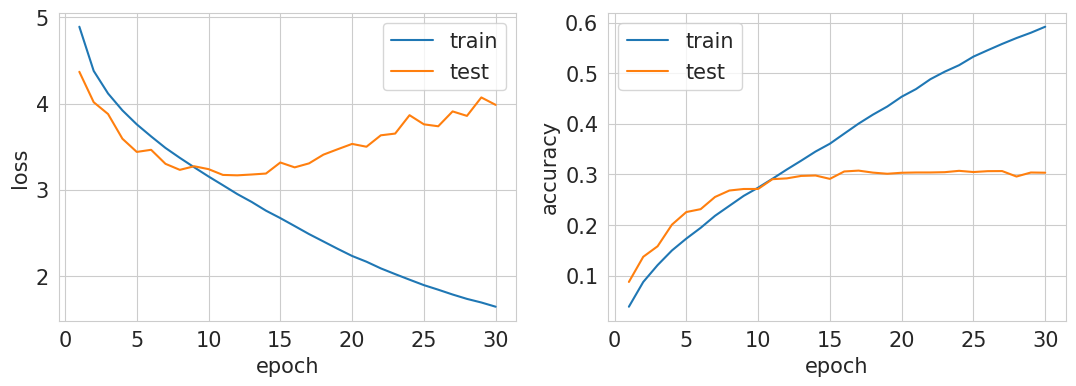

0.3032


In [ ]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    T.ElasticTransform(),
    T.RandomGrayscale(),
    T.RandomInvert(),
    T.RandomEqualize(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

num_epochs = 30
model = SevenVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class EightVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

    def predict(self, x):
        logits = self.forward(x)
        return logits.argmax(dim=1)

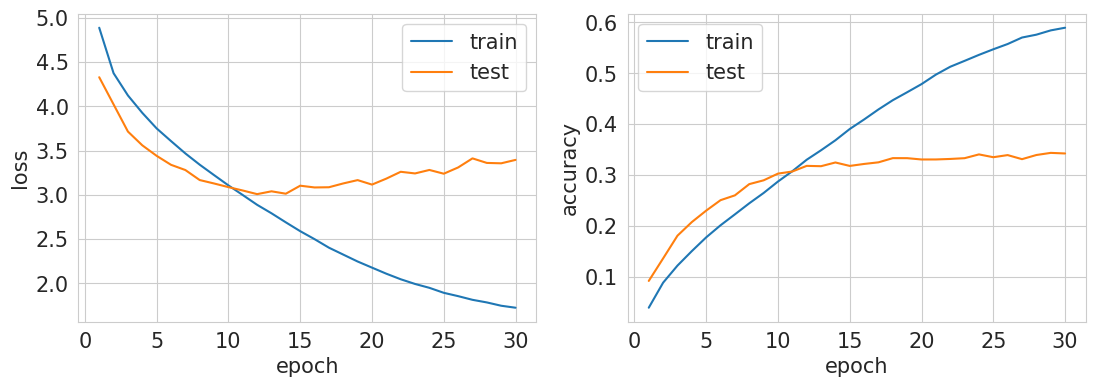

0.34252


In [ ]:
num_epochs = 30
model = EightVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class NineVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

        ind = [0, 4, 8, 11, 14]
        for i in ind:
            torch.nn.init.kaiming_uniform_(self.encoder[i].weight)
        torch.nn.init.kaiming_uniform_(self.added_lay.weight)
        torch.nn.init.kaiming_uniform_(self.linear[0].weight)
        torch.nn.init.kaiming_uniform_(self.linear[3].weight)
        torch.nn.init.kaiming_uniform_(self.linear[6].weight)


    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    T.ElasticTransform(),
    T.RandomGrayscale(),
    T.RandomInvert(),
    T.RandomEqualize(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

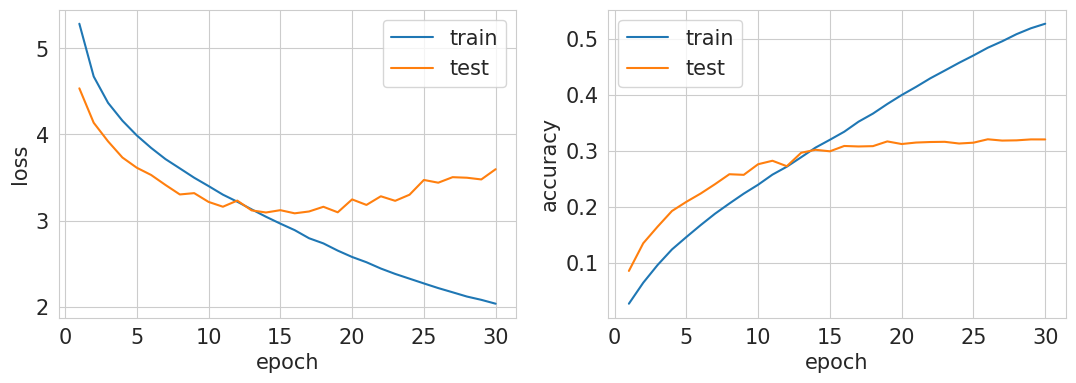

0.32034


In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = NineVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

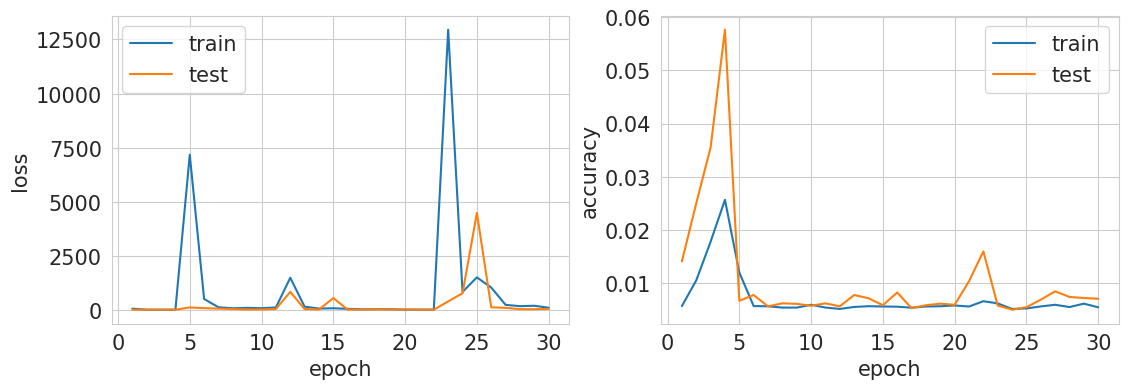

0.00708


In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = NineVrNN(n_classes=200).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, None, criterion, train_loader, test_loader, num_epochs
)

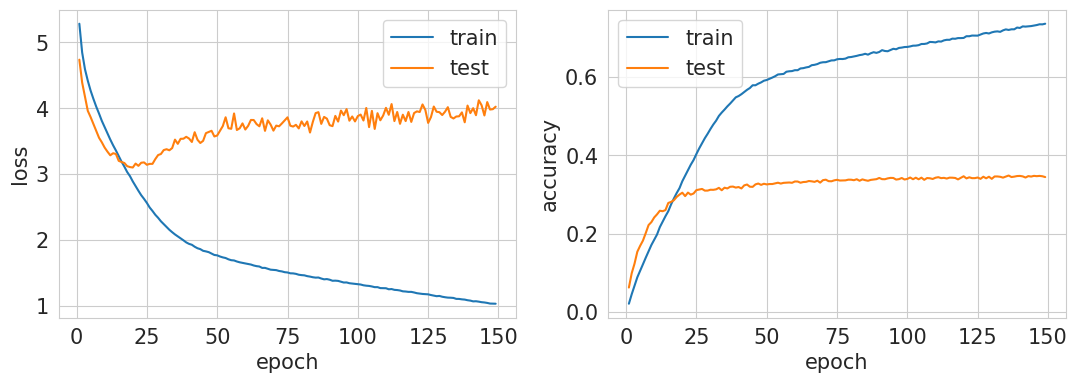

0.34428


Training 150/300:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
num_epochs = 300
torch.autograd.set_detect_anomaly(True)

model = NineVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class TenVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

        ind = [0, 4, 8, 11, 14]
        for i in ind:
            torch.nn.init.kaiming_uniform_(self.encoder[i].weight)
        torch.nn.init.kaiming_uniform_(self.added_lay.weight)
        torch.nn.init.kaiming_uniform_(self.linear[0].weight)
        torch.nn.init.kaiming_uniform_(self.linear[3].weight)
        torch.nn.init.kaiming_uniform_(self.linear[6].weight)


    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

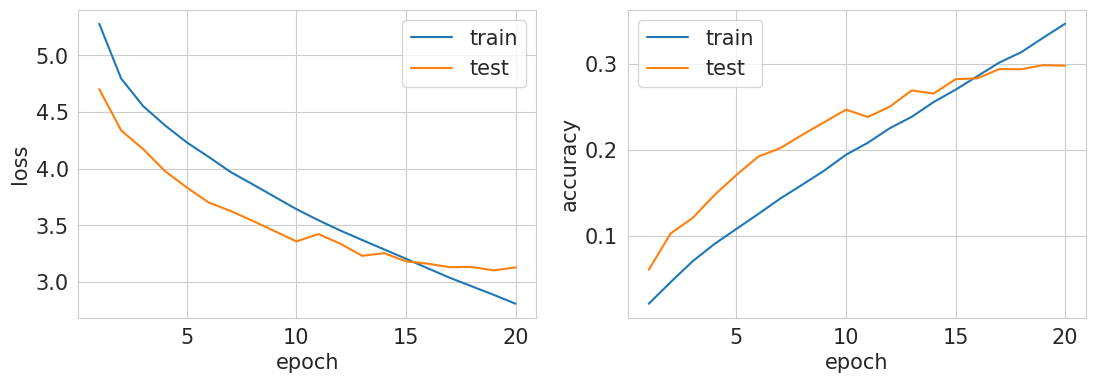

0.29798


Training 21/30:   0%|          | 0/782 [00:00<?, ?it/s]

Exception in thread Thread-381 (_pin_memory_loop):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/opt/conda/lib/python3.10/site-packages/torch/multiprocessing/reductions.py", line 307, in rebuild_storage_fd
    fd = df.detach()
  File "/opt/conda/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:

KeyboardInterrupt: 

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = TenVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class ElevenVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Conv2d(in_channels=96, out_channels=3, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )
        self.resnet = resnet152(num_classes=256 * 3 * 3).to(device)

#         ind = [0, 4]
#         for i in ind:
#             torch.nn.init.kaiming_uniform_(self.encoder[i].weight)
#         torch.nn.init.kaiming_uniform_(self.added_lay.weight)
#         torch.nn.init.kaiming_uniform_(self.linear[0].weight)
#         torch.nn.init.kaiming_uniform_(self.linear[3].weight)
#         torch.nn.init.kaiming_uniform_(self.linear[6].weight)


    def forward(self, x):
#         skip_con = self.added_lay(x)
#         x = self.encoder(x)
        x = self.resnet(x)
#         x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

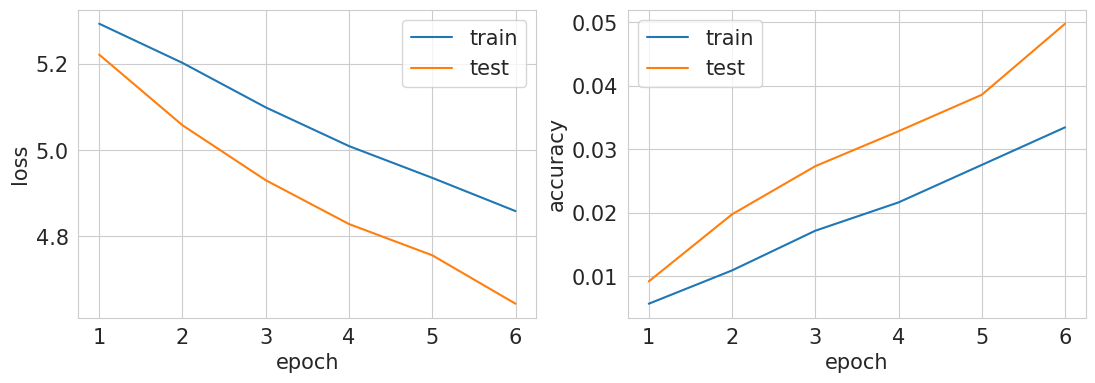

0.04978


Training 7/30:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = ElevenVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
class TwelveVrNN(nn.Module):
    def __init__(self, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 18 x 18)
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),  # (b x 256 x 18 x 18)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 8 x 8)
            nn.Dropout(p=0.1),
            nn.Conv2d(256, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, 3, stride=1, padding='same'),  # (b x 384 x 8 x 8)
            nn.ReLU(),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, 3, stride=1, padding='same'),  # (b x 256 x 8 x 8)
        )
        self.end_encoder = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 3 x 3)
        )
        self.added_lay = nn.Conv2d(in_channels=3, out_channels=256, kernel_size=5, stride=5)  # (b x 256 x 8 x 8)
        self.linear = nn.Sequential(
            nn.Linear(in_features=256 * 3 * 3, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

        ind = [0, 5, 10, 13, 16]
        for i in ind:
            torch.nn.init.kaiming_uniform_(self.encoder[i].weight)
        torch.nn.init.kaiming_uniform_(self.added_lay.weight)
        torch.nn.init.kaiming_uniform_(self.linear[0].weight)
        torch.nn.init.kaiming_uniform_(self.linear[3].weight)
        torch.nn.init.kaiming_uniform_(self.linear[6].weight)


    def forward(self, x):
        skip_con = self.added_lay(x)
        x = self.encoder(x)
        x = self.end_encoder(x + skip_con)
        x = x.reshape((-1, 256 * 3 * 3))
        return self.linear(x)

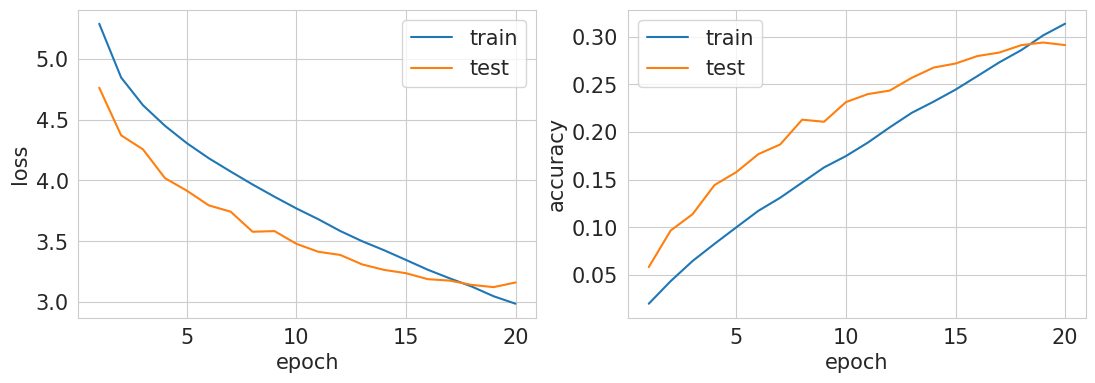

0.29128


Training 21/30:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = TwelveVrNN(n_classes=200).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
# здесь начинается Второе дыхание

In [ ]:
class ResBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, padding='same'),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=3, padding='same'),
            nn.BatchNorm2d(96),
            nn.Dropout(p=0.1),
        )

        self.added_lay = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=1, padding='same')

    def forward(self, x):
        out = self.encoder(x)
        x = self.added_lay(x)
        return x + out


class ThirteenVrNN(nn.Module):
    def __init__(self, device, num_blocks=3, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding='valid'),  # (b x 96 x 38 x 38)
            nn.ReLU(),
            nn.BatchNorm2d(96),
        )

        arr = []
        for i in range(num_blocks):
            arr += [ResBlock()]
        self.resblock = nn.Sequential(*arr)

        self.linear = nn.Sequential(
            nn.Linear(in_features=96 * 38 * 38, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=n_classes),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.resblock(x)
        x = x.reshape((-1, 96 * 38 * 38))
        return self.linear(x)

In [15]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    T.ElasticTransform(),
    T.RandomGrayscale(),
    T.RandomInvert(),
    T.RandomEqualize(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = ThirteenVrNN(device).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

Training 1/30:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_count, out_count):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_count, out_count, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_count),
            nn.ReLU(),
            nn.Conv2d(out_count, out_count, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_count),
        )
        torch.nn.init.kaiming_normal_(self.encoder[0].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.encoder[3].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.constant_(self.encoder[1].weight, 1)
        torch.nn.init.constant_(self.encoder[1].bias, 0)
        torch.nn.init.constant_(self.encoder[4].weight, 1)
        torch.nn.init.constant_(self.encoder[4].bias, 0)

        self.added_lay = nn.Conv2d(in_channels=in_count, out_channels=out_count, kernel_size=1)
        torch.nn.init.kaiming_normal_(self.added_lay.weight, mode="fan_out", nonlinearity="relu")

        self.relu = nn.ReLU()

        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        out = self.encoder(x)
        x = self.added_lay(x)
        x = self.relu(x + out)
        return self.drop(x)


class FourteenVrNN(nn.Module):
    def __init__(self, num_blocks=2, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # nn.Dropout(p=0.1),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1),   # (b, 64, 20, 20)
        )
        torch.nn.init.kaiming_normal_(self.encoder[0].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.constant_(self.encoder[1].weight, 1)
        torch.nn.init.constant_(self.encoder[1].bias, 0)

        arr = []
        for i in range(num_blocks):
            arr += [ResBlock(64, 64)]
        self.resblock1 = nn.Sequential(*arr)

        arr2 = []
        arr2 += [ResBlock(64, 128)]
        for i in range(num_blocks - 1):
            arr2 += [ResBlock(128, 128)]
        self.resblock2 = nn.Sequential(*arr2)

        arr3 = []
        arr3 += [ResBlock(128, 256)]
        for i in range(num_blocks - 1):
            arr3 += [ResBlock(256, 256)]
        self.resblock3 = nn.Sequential(*arr3)

        arr4 = []
        arr4 += [ResBlock(256, 512)]
        for i in range(num_blocks - 2):
            arr4 += [ResBlock(512, 512)]
        self.resblock4 = nn.Sequential(*arr4)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(in_features=256, out_features=n_classes)

    def forward(self, x):
        x = self.encoder(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        # x = self.resblock4(x)
        x = self.avgpool(x)
        x = x.reshape((-1, 256))
        return self.linear(x)

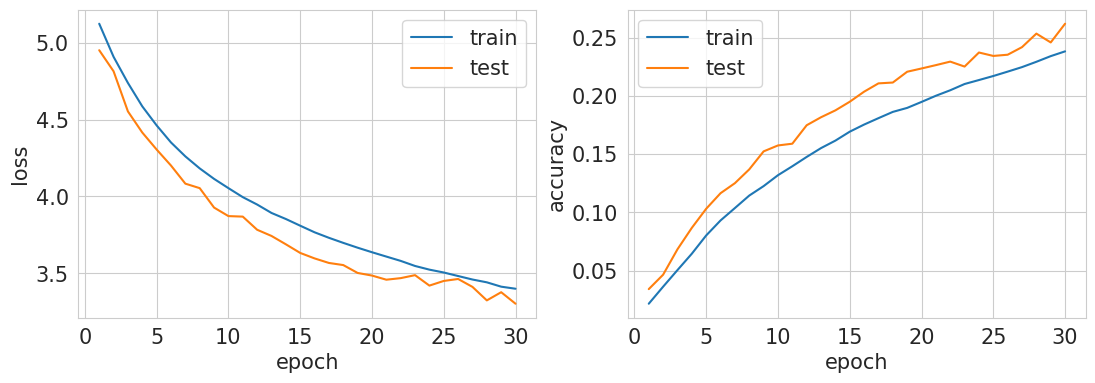

0.26212


In [13]:
# два блока
num_epochs = 30
torch.autograd.set_detect_anomaly(True)

model = FourteenVrNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

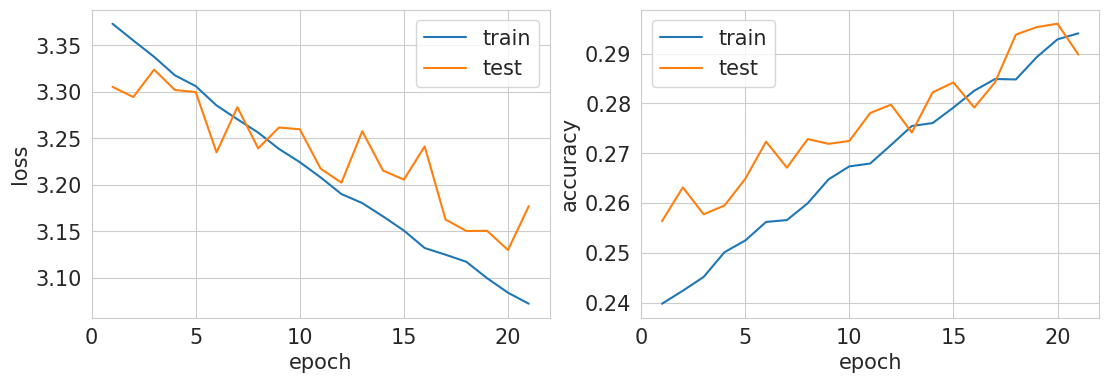

0.28982


Training 22/30:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
# хочу дообучить, чтобы вышла в прямую линия точности
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

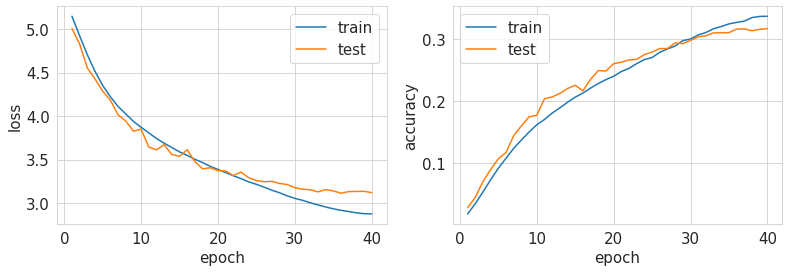

0.31616


In [11]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True)

model = FourteenVrNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

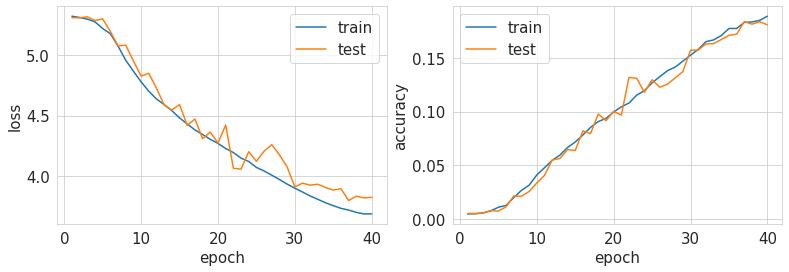

0.1808


In [36]:
num_epochs = 40
# с 3 блоком 34538
torch.autograd.set_detect_anomaly(True) 

model = FourteenVrNN()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(a
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [31]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    # T.ElasticTransform(),
    T.RandomGrayscale(),
    # T.RandomInvert(),
    # T.RandomEqualize(),
    T.RandomHorizontalFlip(), 
    T.ToTensor(),
    T.Normalize(mean=[0., 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

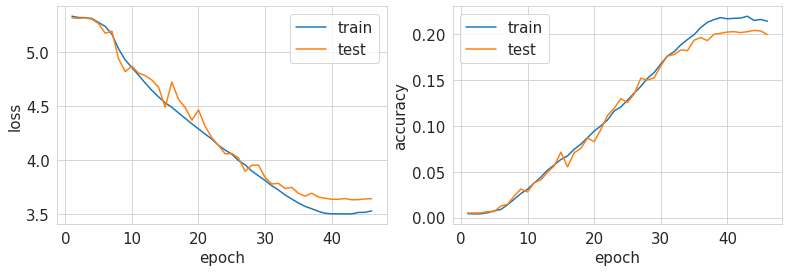

0.19956


Training 47/100:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
num_epochs = 100
torch.autograd.set_detect_anomaly(True) 
# 4 блока
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() dropout decrease
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

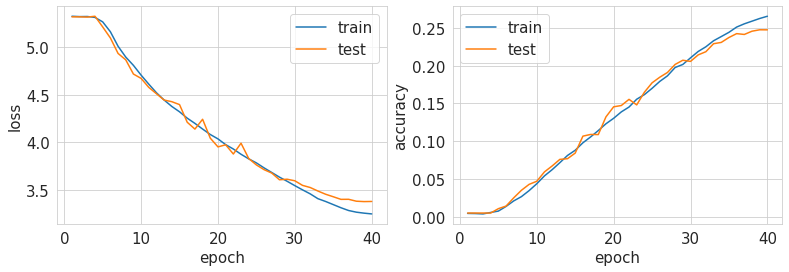

0.24744


In [47]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
# dropout decrease 01
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

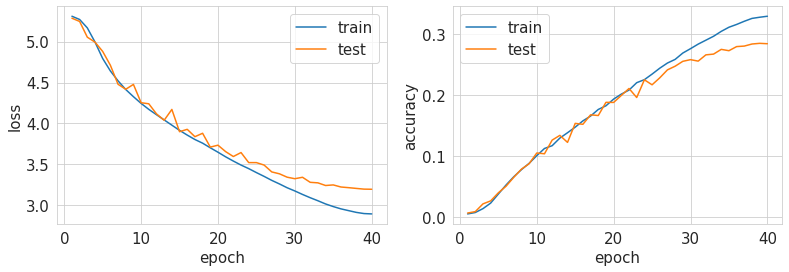

0.28464


In [12]:
#kernel_size=5, stride=1, padding=2
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

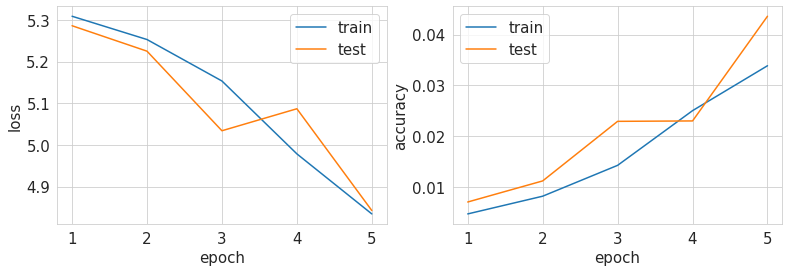

0.0436


Training 6/40:   0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
#kernel_size=7, stride=1, padding=3
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

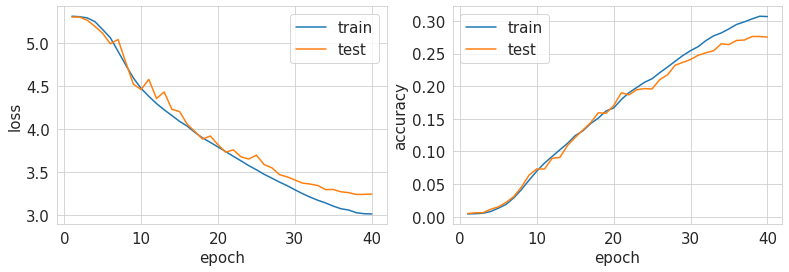

0.27516


In [16]:
# больше dropout
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

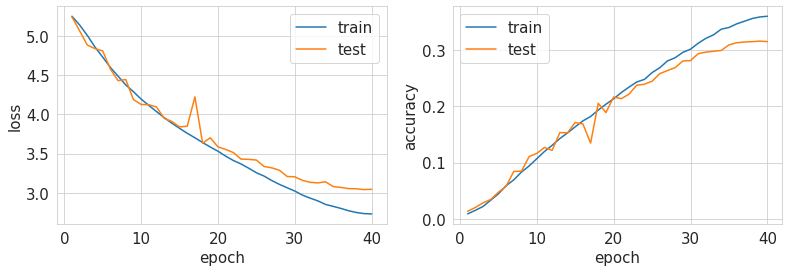

0.31478


In [21]:
# no invert
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

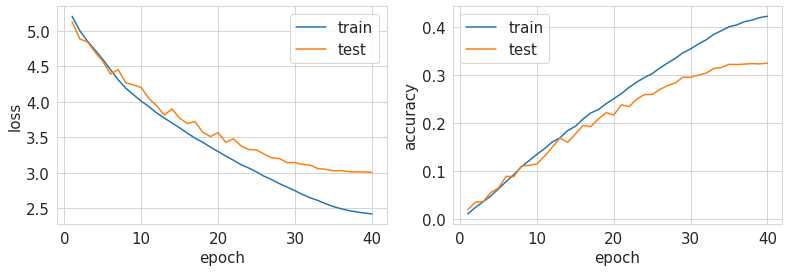

0.3248


In [32]:
# no eq
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

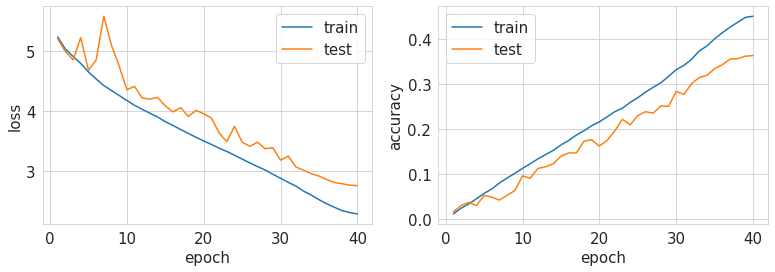

0.3629


In [33]:
# weight
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

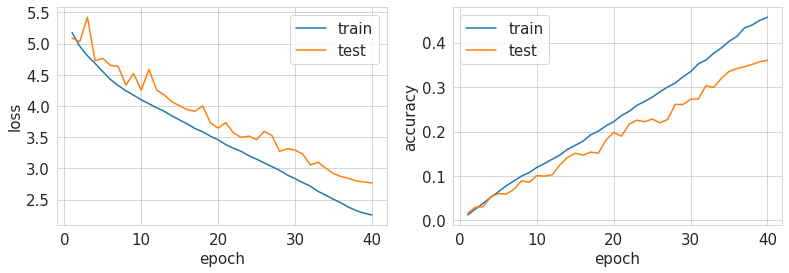

0.36022


In [34]:
# eta min
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.01)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [51]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    T.RandomRotation(degrees=15),
    T.RandomResizedCrop(size=(40, 40)),
    T.RandomHorizontalFlip(), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

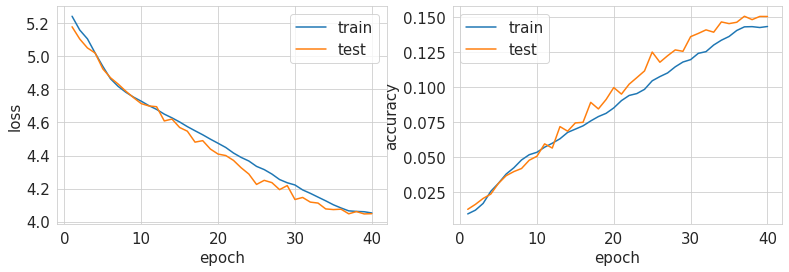

0.15018


In [52]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True)
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [62]:
class ResBlock(nn.Module):
    def __init__(self, in_count, out_count):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_count, out_count, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_count),
            nn.ReLU(),
            nn.Conv2d(out_count, out_count, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_count),
        )
        torch.nn.init.kaiming_normal_(self.encoder[0].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.kaiming_normal_(self.encoder[3].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.constant_(self.encoder[1].weight, 1)
        torch.nn.init.constant_(self.encoder[1].bias, 0)
        torch.nn.init.constant_(self.encoder[4].weight, 1)
        torch.nn.init.constant_(self.encoder[4].bias, 0)

        self.added_lay = nn.Conv2d(in_channels=in_count, out_channels=out_count, kernel_size=1)
        torch.nn.init.kaiming_normal_(self.added_lay.weight, mode="fan_out", nonlinearity="relu")

        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.encoder(x)
        x = self.added_lay(x)
        return self.relu(x + out)

class FifteenVrNN(nn.Module):
    def __init__(self, num_blocks=2, n_classes=200):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        torch.nn.init.kaiming_normal_(self.encoder[0].weight, mode="fan_out", nonlinearity="relu")
        torch.nn.init.constant_(self.encoder[1].weight, 1)
        torch.nn.init.constant_(self.encoder[1].bias, 0)
        
        self.drop = nn.Dropout(p=0.1)

        arr = []
        for i in range(num_blocks):
            arr += [ResBlock(64, 64)]
        self.resblock1 = nn.Sequential(*arr)
        
        self.drop1 = nn.Dropout(p=0.1)

        arr2 = []
        arr2 += [ResBlock(64, 128)]
        for i in range(num_blocks - 1):
            arr2 += [ResBlock(128, 128)]
        self.resblock2 = nn.Sequential(*arr2)
        
        self.drop2 = nn.Dropout(p=0.1)

        arr3 = []
        arr3 += [ResBlock(128, 256)]
        for i in range(num_blocks - 1):
            arr3 += [ResBlock(256, 256)]
        self.resblock3 = nn.Sequential(*arr3)
        
        self.drop3 = nn.Dropout(p=0.1)

        arr4 = []
        arr4 += [ResBlock(256, 512)]
        for i in range(num_blocks - 1):
            arr4 += [ResBlock(512, 512)]
        self.resblock4 = nn.Sequential(*arr4)
        
        self.drop4 = nn.Dropout(p=0.1)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Sequential(
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=n_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        # x = self.drop(x)
        x = self.resblock1(x)
        # x = self.drop1(x)
        x = self.resblock2(x)
        # x = self.drop2(x)
        x = self.resblock3(x)
        # x = self.drop3(x)
        # x = self.resblock4(x)
        # x = self.drop4(x)
        x = self.avgpool(x)
        x = x.reshape((-1, 256))
        return self.linear(x)

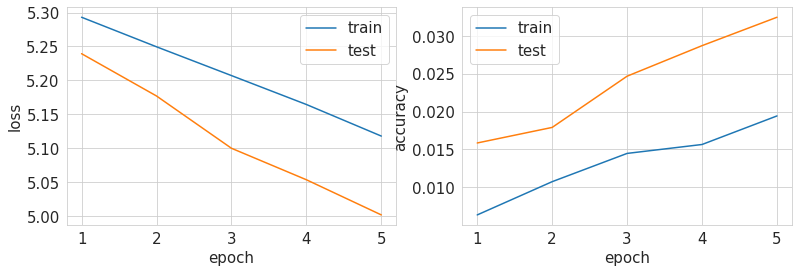

0.03248


Training 6/40:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [64]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FifteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

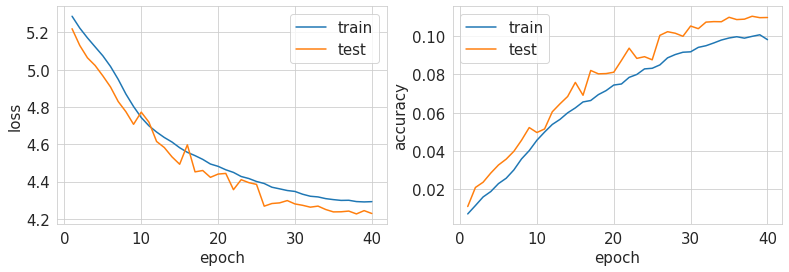

0.1096


In [66]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [77]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    # T.ElasticTransform(),
    T.RandomGrayscale(),
    T.RandomInvert(),
    T.RandomEqualize(),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.5, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

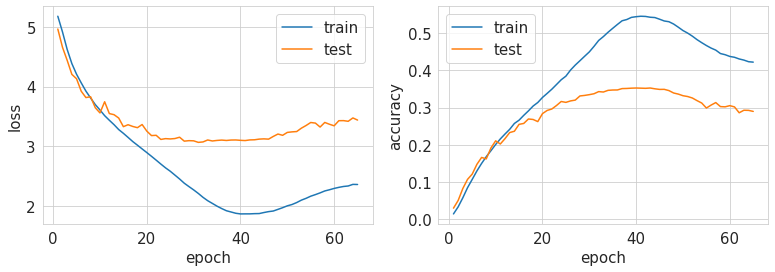

0.2897


Training 66/100:   0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [78]:
num_epochs = 100
torch.autograd.set_detect_anomaly(True) 

model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [ ]:
# torch.save(net.state_dict(), "weights.pt")
# net.load_state_dict(torch.load("weights.pt"))

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# итоговый вариант

In [22]:
# не он
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(p=0.1),
    T.RandomGrayscale(),
    T.RandomHorizontalFlip(p=0.2), 
    T.ToTensor(),
    T.Normalize(mean=[0., 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.1, train=True, load_to_ram=True, transform=train_transform)

test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

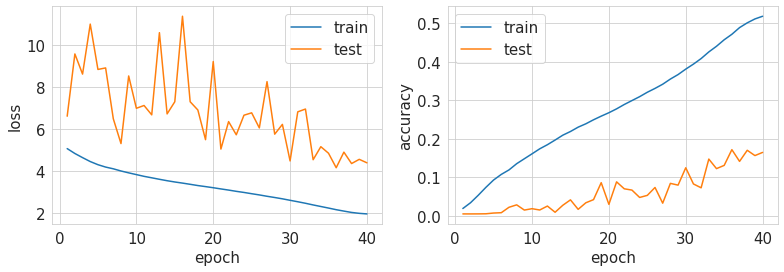

0.16492


In [9]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

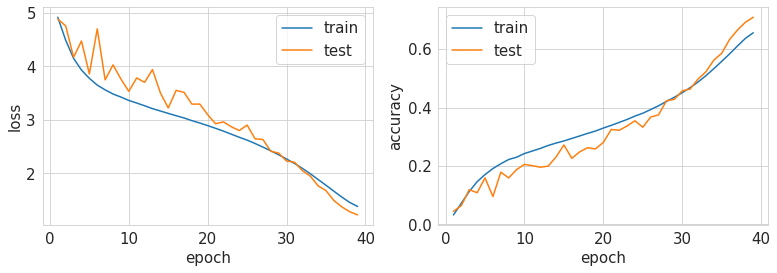

0.70916


Training 40/40:   0%|          | 0/1407 [00:00<?, ?it/s]

In [ ]:
num_epochs = 40
torch.autograd.set_detect_anomaly(True) 
model = FourteenVrNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss() 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

In [24]:
test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_transform = T.Compose([
    T.RandomVerticalFlip(),
    T.RandomGrayscale(),
    T.RandomHorizontalFlip(), 
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_dataset = ImageDataset(root=PATH, data=data, test_size=0.1, train=True, load_to_ram=True, transform=test_transform)
aug_train_dataset =  ImageDataset(root=PATH, data=data, test_size=0.1, train=True, load_to_ram=True, transform=train_transform)

train_dataset = base_train_dataset + aug_train_dataset
test_dataset = ImageDataset(root=PATH, data=data, train=False, load_to_ram=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
answer = pd.read_csv(PATH + 'sample_submission.csv')
answer.head()

In [ ]:
test_dataset = ImageDataset(root=PATH, data=answer, train=False, load_to_ram=True, transform=test_transform, trainval=False)
test_loader = DataLoader(test_dataset, batch_size=answer.shape[0], shuffle=False, pin_memory=True, num_workers=4)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=answer.shape[0] // 100, shuffle=False, pin_memory=True, num_workers=4)

In [ ]:
i = 100
for images, labels in test_loader:
    images = images.to(device)
    y_pred = model(images)

    y_pred = y_pred.argmax(dim=1).cpu()
    answer.iloc[i - 100:i, 1] = y_pred.tolist()

    i += 100

In [ ]:
# answer['Category'] = y_pred
answer.set_index('Id', inplace=True)
answer.head()

In [ ]:
answer.to_csv('solution.csv')